# Déconvolution de Wiener

Samuel Michaud / Tom Pauwels

 # Import


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftn, ifftn
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

# Fonction de déconvolution

In [2]:
def wiener_deconv(image, psf, balance, reg=None, is_real=True, clip=True):
    # On cree une image pour le PSF avec du padding pour avoir la meme taille que l'image
    pad_psf = np.zeros_like(image)
    psf_shape = psf.shape
    pad_psf[:psf_shape[0], :psf_shape[1]] = psf

    # On effectue les transformations de Fourier de l'image et du PSF
    image_ft = fftn(image)
    psf_ft = fftn(pad_psf)
    
    # On defini le filtre Laplacien si la regularisation (reg) vaut "None"
    if reg is None:
        reg = np.zeros_like(image)
        reg[1, 0] = -1
        reg[-1, 0] = -1
        reg[0, 1] = -1
        reg[0, -1] = -1
        reg[0, 0] = 4
    
    # On complete reg a la meme taille que l'image
    pad_reg = np.zeros_like(image)
    reg_shape = reg.shape
    pad_reg[:reg_shape[0], :reg_shape[1]] = reg

    # On effectue la transformation de Fourier sur la regularisation
    reg_ft = fftn(pad_reg)
    
    # On effectue la deconvolution de Wiener
    numerator = np.conj(psf_ft) * image_ft
    denominator = np.abs(psf_ft)**2 + balance * np.abs(reg_ft)**2
    deconv_ft = numerator / denominator
    
    # On effectue la transformation de Fourier inverse pour obtenir l'image deconvoluee
    # On prend la partie reelle si il s'agit d'une image reelle
    if is_real:
        deconv_image = np.real(ifftn(deconv_ft))
    else:
        deconv_image = ifftn(deconv_ft)
    # On clip les valeurs de l'image entre 0 et 1 si besoin
    if clip:
        deconv_image = np.clip(deconv_image, 0, 1)

    # On recentre l'image
    final_image = np.hstack((deconv_image[:, -psf_shape[0]//2:], deconv_image[:, :-psf_shape[0]//2]))
    final_image = np.vstack((final_image[-psf_shape[0]//2:, :], final_image[:-psf_shape[0]//2, :]))

    # On retourne la valeur absolue de l'image deconvoluee pour eviter les valeurs negatives
    return np.abs(final_image)

# Tests

### Affichage de l'image de base

Chargement de l'image de base

In [3]:
# On charge l'image
image_path = "images/cropped-1920-1080-666343.png"
image = plt.imread(image_path)
# On convertit l'image en niveaux de gris si elle est en couleur
if image.ndim == 3:
    image = image.mean(axis=2)

Affichage de cette image

(-0.5, 1919.5, 1079.5, -0.5)

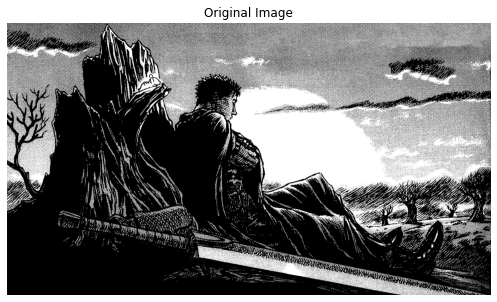

In [4]:
# On affiche l'image originale
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

### Fonctions de test 

Gaussian PSF

In [5]:
# On cree un PSF gaussien
def gaussian_psf(size, sigma):
    psf = np.zeros((size, size))
    center = size // 2
    psf[center, center] = 1
    psf = gaussian_filter(psf, sigma=sigma)
    return psf / psf.sum()

Fonction d'affichage

In [6]:
def affiche_comparaison(original_image, modified_image, final_image):
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 1, 1)
    plt.title('Original Image')
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 1, 2)
    plt.title('Modified Image')
    plt.imshow(modified_image, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 1, 3)
    plt.title('Final Image')
    plt.imshow(final_image, cmap='gray')
    plt.axis('off')


On utilisera également la fonction <u>convolve2d</u> pour ajouter un bruit sur l'image

### Test de déconvolution sur une image floutée

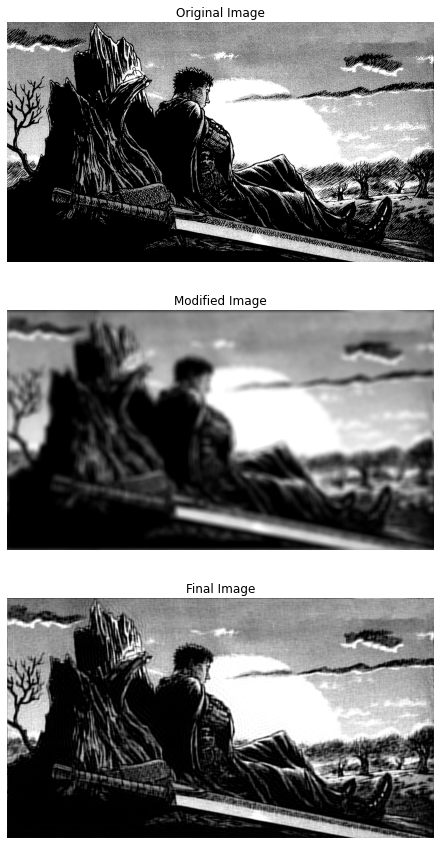

In [7]:
psf_size = 30
psf_sigma = 10
psf = gaussian_psf(psf_size, psf_sigma)

# On floute l'image avec le PSF
blurred_image = convolve2d(image, psf, mode='same', boundary='wrap')

# On deconvolue l'image floutee avec la deconvolution de Wiener
balance = 0.01
restored_image = wiener_deconv(blurred_image, psf, balance)

affiche_comparaison(image, blurred_image, restored_image)

On essaye pour plusieurs valeurs de sigma pour le floutage

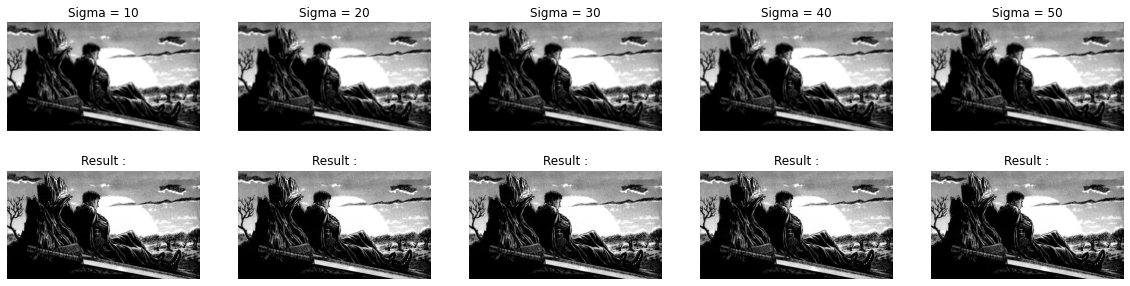

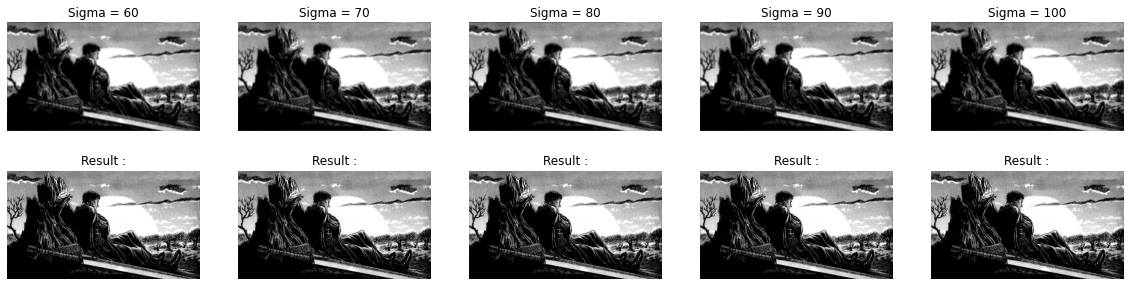

In [8]:
psf_size = 15
balance = 0.01
plt.figure(figsize=(20, 5))

for sigma in range(1,11):
    if sigma == 6: #La moitié
        plt.figure(figsize=(20, 5))

    psf = gaussian_psf(psf_size, sigma * 10)
    blurred_image = convolve2d(image, psf, mode='same', boundary='wrap')
    restored_image = wiener_deconv(blurred_image, psf, balance)

    index = (sigma-1) % 5 + 1

    plt.subplot(2, 5, index)
    plt.title("Sigma = " + str(sigma * 10))
    plt.imshow(blurred_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 5, index + 5)
    plt.title('Result :')
    plt.imshow(restored_image, cmap='gray')
    plt.axis('off')

### Test de déconvolution sur une image floutée

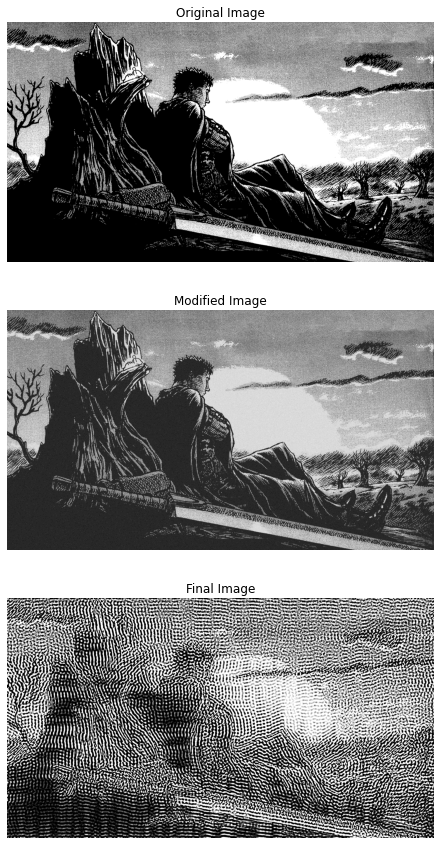

In [9]:
# On ajoute du bruit a l'image floutee
noise_std = 0.05
noisy_image = image + noise_std * np.random.randn(*blurred_image.shape)

# On deconvolue l'image bruitee avec la deconvolution de Wiener
balance = 0.01
restored_image = wiener_deconv(noisy_image, psf, balance)

affiche_comparaison(image, noisy_image, restored_image)

Affichage

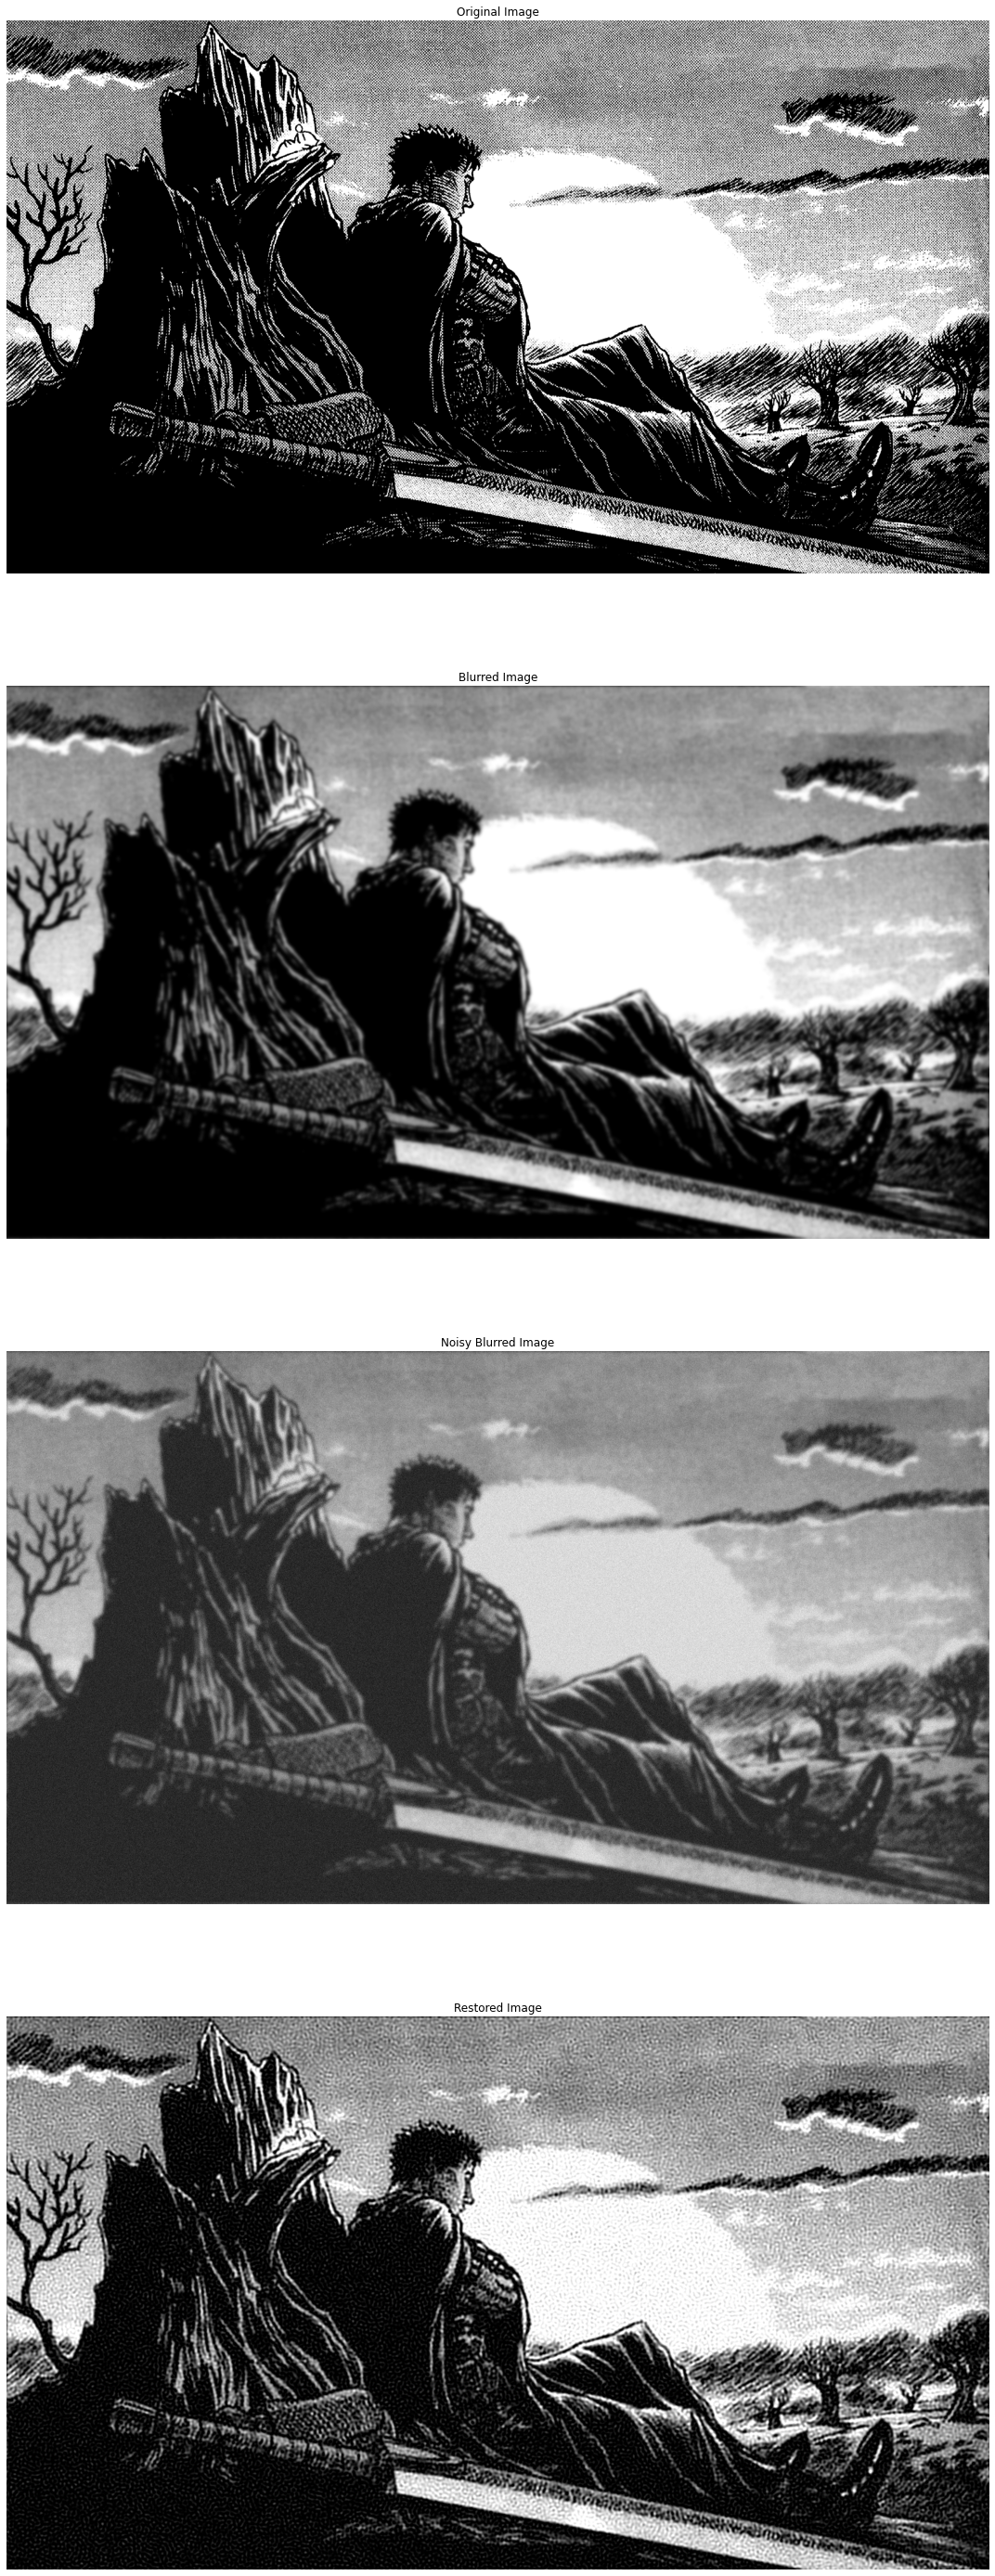

In [10]:
psf_size = 15
psf_sigma = 3
psf = gaussian_psf(psf_size, psf_sigma)

# On floute l'image avec le PSF
blurred_image = convolve2d(image, psf, mode='same', boundary='wrap')

# On ajoute du bruit a l'image floutee
noise_std = 0.05
noisy_blurred_image = blurred_image + noise_std * np.random.randn(*blurred_image.shape)

# On deconvolue l'image bruitee avec la deconvolution de Wiener
balance = 0.01
restored_image = wiener_deconv(noisy_blurred_image, psf, balance)

# On affiche les images
plt.figure(figsize=(15, 40))
plt.subplot(4, 1, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(4, 1, 2)
plt.title('Blurred Image')
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')

plt.subplot(4, 1, 3)
plt.title('Noisy Blurred Image')
plt.imshow(noisy_blurred_image, cmap='gray')
plt.axis('off')

plt.subplot(4, 1, 4)
plt.title('Restored Image')
plt.imshow(restored_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
